### test GPU

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import keras
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, BatchNormalization,Concatenate, concatenate, Reshape, Activation,Lambda, AveragePooling2D
import keras.backend as K
import numpy as np

In [3]:
IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

if IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    MERGE_AXIS = -1

### fonction qui récupère le VGG encodeur pré entrainé imagenet

In [4]:
def get_vgg_encoder(input_height=224,  input_width=224, pretrained='imagenet', channels=3):

    #doit etre un multiple de 32 car image divisée par 32
    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING)(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',  name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING)(x)
    f5 = x

    if pretrained == 'imagenet':
        #telechargement du fichier de poids 
        #astuce pour extraire le nom en dernier de l'url avec pretrained_url.split("/")[-1]
        VGG_Weights_path = keras.utils.get_file(pretrained_url.split("/")[-1], pretrained_url)
        #chargement : https://keras.io/api/models/model_saving_apis/#loadweights-method
            #by_name=True: to load weights by name => necessite d avoir les memes noms de couches
        Model(img_input, x).load_weights(VGG_Weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

### fonction VGG unet et PSP net

In [5]:
def vgg_unet(n_classes, input_height=416, input_width=608, encoder_level=3, channels=3):

    model = _unet(n_classes, get_vgg_encoder,input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "vgg_unet"
    return model

def vgg_pspnet(n_classes,  input_height=384, input_width=576, channels=3):

    model = _pspnet(n_classes, get_vgg_encoder,input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "vgg_pspnet"
    return model

In [6]:
def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416, input_width=608, channels=3):

    img_input, levels = encoder(input_height=input_height, input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    #rajoute du padding de 0 autour 
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    #normalisation de la sortie
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING, name="seg_feats"))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',data_format=IMAGE_ORDERING)(o)
    ########################
    
    oh = Model(img_input, o).output_shape[1]
    ow = Model(img_input, o).output_shape[2]
    nc = Model(img_input, o).output_shape[3]
    ih = Model(img_input, o).input_shape[1]
    iw = Model(img_input, o).input_shape[2]
    
    #segmentation
    o = (Reshape((Model(img_input, o).output_shape[1]*Model(img_input, o).output_shape[2], -1)))(o)
    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    
    model.output_height = oh
    model.output_width = ow
    model.n_classes = nc
    model.input_height = ih
    model.input_width = iw
    
    return model

In [7]:
def resize_image(inp,  s, data_format):

    try:

        return Lambda(lambda x: K.resize_images(x,
                                                height_factor=s[0],
                                                width_factor=s[1],
                                                data_format=data_format,
                                                interpolation='bilinear'))(inp)

    except Exception as e:
        # if keras is old, then rely on the tf function
        # Sorry theano/cntk users!!!
        assert data_format == 'channels_last'
        assert IMAGE_ORDERING == 'channels_last'

        import tensorflow as tf

        return Lambda(
            lambda x: tf.image.resize_images(
                x, (K.int_shape(x)[1]*s[0], K.int_shape(x)[2]*s[1]))
        )(inp)
    
def pool_block(feats, pool_factor):

    if IMAGE_ORDERING == 'channels_first':
        h = K.int_shape(feats)[2]
        w = K.int_shape(feats)[3]
    elif IMAGE_ORDERING == 'channels_last':
        h = K.int_shape(feats)[1]
        w = K.int_shape(feats)[2]

    pool_size = strides = [
        int(np.round(float(h) / pool_factor)),
        int(np.round(float(w) / pool_factor))]

    x = AveragePooling2D(pool_size, data_format=IMAGE_ORDERING,
                         strides=strides, padding='same')(feats)
    x = Conv2D(512, (1, 1), data_format=IMAGE_ORDERING,
               padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = resize_image(x, strides, data_format=IMAGE_ORDERING)

    return x

def _pspnet(n_classes, encoder,  input_height=384, input_width=576, channels=3):

    assert input_height % 192 == 0
    assert input_width % 192 == 0

    img_input, levels = encoder(input_height=input_height,  input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    pool_factors = [1, 2, 3, 6]
    pool_outs = [o]

    for p in pool_factors:
        pooled = pool_block(o, p)
        pool_outs.append(pooled)

        
    o = Concatenate(axis=MERGE_AXIS)(pool_outs)

    o = Conv2D(512, (1, 1), data_format=IMAGE_ORDERING, use_bias=False , name="seg_feats" )(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2D(n_classes, (3, 3), data_format=IMAGE_ORDERING,padding='same')(o)
    
    o = resize_image(o, (8, 8), data_format=IMAGE_ORDERING)

    ######################
    oh = Model(img_input, o).output_shape[1]
    ow = Model(img_input, o).output_shape[2]
    nc = Model(img_input, o).output_shape[3]
    ih = Model(img_input, o).input_shape[1]
    iw = Model(img_input, o).input_shape[2]
    
    #segmentation
    o = (Reshape((Model(img_input, o).output_shape[1]*Model(img_input, o).output_shape[2], -1)))(o)
    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    
    model.output_height = oh
    model.output_width = ow
    model.n_classes = nc
    model.input_height = ih
    model.input_width = iw
    
    return model

### creation des modèles de segmentation

In [8]:
#model = vgg_unet(n_classes=8 ,  input_height=224, input_width=224)
model = vgg_unet(n_classes=8 ,  input_height=256, input_width=512)
#model = vgg_pspnet(n_classes=8,  input_height=384, input_width=576)

#par defaut on prend 416x608
#on charge l'encodeur VGG16 416x608 (defaut 224x224) qui renvoie l'ing_input et les levels/ blocs [f1, f2, f3, f4, f5]
    # les tailles doivent etres des multiples de 32 (assert % 32==0 dans le code) =>416 et 608 sont ok
        #pourquoi 32? car la partie CNN du VGG divise par 32 la taille apres 5 maxpooling consecutifs
    # les channels couleurs sont à la fin
    # archi: 
        #2 CL de 64 filtres /maxpooling(2,2) -> f1
        #2 CL de 128 filtres /maxpooling(2,2) -> f2
        #3 CL de 256 filtres /maxpooling(2,2) -> f3
        #3 CL de 512 filtres /maxpooling(2,2) -> f4
        #3 CL de 512 filtres /maxpooling(2,2) -> f5
    # chargement des poids VGG16 préentrainés pour imagenet , necessite d'avoir les memes noms que dan sle github de fchollet pour le VGG16
    #renvoie le format de l'input et les blocks préentrainés
    
    #on plug le unet en oubliant le 5eme block du vgg
        #1 CL de 512 filtres avec normalisation
        #1 upsampling x2 avec concatenation f3 selon l'axe des channels de filtres puis 1CL de 256 filtres avec normalisation
        #1 upsampling x2 avec concatenation f2 selon l'axe des channels de filtre puis 1CL de 128 filtres avec normalisation
        #1 upsampling x2 avec concatenation f1 hypothetique selon l'axe des channels de filtre puis 1CL de 64 filtres avec normalisation
        #1 CL à n classes

In [9]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

### création des métriques

In [10]:
from tensorflow.python.keras import backend as K

def flat_dice(y_true, y_pred, smooth = 0.001):
    """union et intersection calculée sur 1 seule grosse classe 
        de dimension height*width*nclasses (voir *batch_size)"""
    
    #type F1 score
    #reshape en 1D / attention voir si ok avec le keras.backend pas si sur en focntion des version
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #on fait l intersection des 0 et des 1
    intersection = K.sum(K.flatten(y_true) * K.flatten(y_pred)) #intersection totale
    union = K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) #union totale sans retirer l'intersection
    flat_dice = (2. * intersection + smooth) / (union + smooth) # quand l'intersection est max, 2 intersections = union sans retirer l'intersection = cercles concentriques
    
    #intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    #union=K.sum(y_true, axis=[1,2,3])+K.sum(y_pred, axis=[1,2,3])
    #dice = K.mean((2. * intersection + smooth) / (union + smooth),axis=0]
    return flat_dice

def flat_iou(y_true, y_pred,smooth = 0.001):
    #reshape en 1D / attention voir si ok avec le keras.b&ackend pas si sur en focntion des version
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #on fait l intersection des 0 et des 1
    
    #attention ne fait pas la moyenne du resultat pour chaque classe
    intersection = K.sum(K.flatten(y_true) * K.flatten(y_pred)) 
    union = K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) - intersection #union totale sans retirer l'intersection
    flat_iou = (intersection + smooth) / (union + smooth) #
    
    #intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    #union=K.sum(y_true, axis=[1,2,3])+K.sum(y_pred, axis=[1,2,3])
    #dice = K.mean((2. * intersection + smooth) / (union + smooth),axis=0]
    return flat_iou

def mean_dice(y_true, y_pred, smooth = 0.001):
    """union et intersection calculée par classe puis moyennée"""
    
    #type F1 score
    #reshape en 1D / attention voir si ok avec le keras.backend pas si sur en focntion des version
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #on fait l intersection des 0 et des 1

    intersection = K.sum(y_true * y_pred, axis=[0,1])
    union=K.sum(y_true, axis=[0,1])+K.sum(y_pred, axis=[0,1])
    mean_dice = K.mean((2. * intersection + smooth) / (union + smooth))
    return mean_dice

def mean_iou(y_true, y_pred, smooth = 0.001):
    """union et intersection calculée par classe puis moyennée"""
    
    #type F1 score
    #reshape en 1D / attention voir si ok avec le keras.backend pas si sur en focntion des version
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #on fait l intersection des 0 et des 1

    intersection = K.sum(y_true * y_pred, axis=[0,1])
    union=K.sum(y_true, axis=[0,1])+K.sum(y_pred, axis=[0,1])-intersection
    mean_iou = K.mean((intersection + smooth) / (union + smooth))
    return mean_iou

def shape0(y_true, y_pred,smooth = 1):
    return K.flatten(y_true).shape
def shape1(y_true, y_pred,smooth = 1):
    return y_true.shape[1]
def shape2(y_true, y_pred,smooth = 1):
    return y_true.shape[2]
def shape3(y_true, y_pred,smooth = 1):
    return y_true.shape[3]

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[mean_dice, mean_iou, flat_dice, flat_iou,'accuracy'])

### stockage du config file du modèle

In [12]:
import os, json
config_file = "vgg_unet_256_512/_config.json"
#config_file = "vgg_pspnet_384_576/_config.json"
dir_name = os.path.dirname(config_file)

if ( not os.path.exists(dir_name) )  and len( dir_name ) > 0 :
    os.makedirs(dir_name)

with open(config_file, "w") as f:
    json.dump({
                "model_class": model.model_name,
                "n_classes": model.n_classes,
                "input_height": model.input_height,
                "input_width": model.input_width,
                "output_height": model.output_height,
                "output_width": model.output_width
            }, f)
    

### fonction d'augmentation

In [13]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

#pipeline /augmenteur sequentiel
def _load_augmentation_aug_all(other=0):
    """ Load image augmentation model
        other va de 0 à 5 et représente le nombre de transfo couteuses max:
            0 veut dire aucune transfo couteuse
            5 veut dire un chiffre entre 0 et 5 transfo couteuses"""

    def sometimes(aug):
        return iaa.Sometimes(0.5, aug)

    return iaa.Sequential(
        [
            #MIRROIR
            # imgaug flip/mirroir
            iaa.Fliplr(0.5),  # mirroir horizontal avec une proba de realisation de 50%
            iaa.Flipud(0.2),  # mirroir vertical avec une proba de 20%
            
            #CROP
            # crop & pad avec une proba de realisation de 50%, l'image finale reste à la meme dimension
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1), # crop height by -5% (top & bottom) / pad width by 10% 
                pad_mode='constant', #le padding se fait en donnant une valeur constante  aux nouveaux pixels
                pad_cval=(50, 255) #cette valeur constante est comprise entre 0 et 255
            )),
            
            #TRANSFO AFFINE / SCALING
            #scaling avec avec une proba de realisation de 50%
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, #zoom in/it entre 80 et 120%
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, #translation de -20 à +20%
                rotate=(-45, 45),  # rotation -45 to +45 degrees
                shear=(-16, 16),  # cisaillement -16 to +16 degrees
                order=[0, 1], #fast interpolation
                cval=(50, 255), #si mode constant pixel remplacé par une valeur entre 0 et 255 / on choisit un nombre superieures aux instance du masque
                mode='constant'
            )),
            #AUTRES TRANSFO A UTILISER AVEC PARCIMONIE
            iaa.SomeOf((0, other), #DE 0 0 5 DES TRANSFO SUIVANTES EXECUTEES
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), #ASSEZ LENT  de 20 à 200 superpixels remplacés par leur couleur moyenne 
                #BLUR / troubler
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), #gaussian blur
                    iaa.AverageBlur(k=(2, 7)), #average blur
                    iaa.MedianBlur(k=(3, 11)), #median blur
                ]),
                #FINESSE           
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images / finess
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images / clair-sombre
                #DETECTION DE BORDS PAR ALPHABLENDING
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                #BRUIT GAUSSIEN
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                #SUPPRESION DE PIXELS
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), #inverison de couleur
                iaa.Add((-10, 10), per_channel=0.5), #luminosité
                iaa.AddToHueAndSaturation((-20, 20)), #teinte et saturation

                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply((0.5, 1.5), per_channel=True),
                        background=iaa.contrast.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.contrast.LinearContrast((0.5, 2.0), per_channel=0.5), #contraste
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),  # move pixels locally around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),  # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )            

        ],
        random_order=True
    )

### creation de la liste des paires de chemins images/GT

In [14]:
import os
from tensorflow.python.keras.preprocessing import image
import time

def im_seg_pairs():
    """renvoie une liste de listes de pairs de chemins images/masks
        en [0] : la paire train 69%
        en [1] : la paire val 14%
        en [2] : la paire test 17% """
    
    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    #images_path="input/dataset1/images_prepped_train_light/"
    #segs_path = "input/dataset1/annotations_prepped_train_light/"
    
    images_path_main = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/"
    segs_path_main = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/"
    
    return_pairs = []

    for dir_type in ["train","val","test"]:
        images_path=os.path.join(images_path_main, dir_type)
        segs_path=os.path.join(segs_path_main, dir_type)

        #liste
        image_files = []
        return_type_value = []
        #dict
        segmentation_files = {}

        #retourne la liste des repertoires et/ou fichiers dans le repertoire d'images
        for dir_city in os.listdir(images_path):
            for dir_entry in os.listdir(os.path.join(images_path, dir_city)):
                #si le fichier existe, est un format image et n'est pas completement noire 
                #with image.load_img(os.path.join(images_path, dir_city, dir_entry)) as imgg: #fonction lente
                    if os.path.isfile(os.path.join(images_path, dir_city, dir_entry))\
                    and os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    #and np.max(imgg)>0: #fonction lente
                        #on separe en nom/extension
                        file_name, file_extension = os.path.splitext(dir_entry)
                        #on ajoute à la liste des images le triplet(nom sans extension et sans suffixe, extension, chemin)
                        image_files.append((file_name.rstrip("_leftImg8bit"), file_extension,os.path.join(images_path, dir_city, dir_entry)))

        #retourne la liste des chemins des masks sous forme de dictionnaire pour etre facilement atteignable     
        for dir_city in os.listdir(segs_path):
            for dir_entry in os.listdir(os.path.join(segs_path, dir_city)):
                #si le fichier existe , est un labelids,  est un format image et n'est pas completement noire
                #with image.load_img(os.path.join(segs_path, dir_city, dir_entry)) as imgg: #fonction lente
                    if os.path.isfile(os.path.join(segs_path, dir_city, dir_entry)) \
                    and "_labelIds" in os.path.splitext(dir_entry)[0] \
                    and os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
                    #and np.max(imgg)>0: #fonction lente
                        #on separe en nom/extension
                        file_name, file_extension = os.path.splitext(dir_entry)
                        #on popûle le dictionnaire de mask avec en valeur un duo extension/chemin
                        segmentation_files[file_name.rstrip("_gtFine_labelIds")] = (file_extension, os.path.join(segs_path, dir_city, dir_entry))
    
        #boucle sur la liste du triplet image
        for image_file, _ , image_full_path in image_files:
            #si nom de l'image dispo dans le dictionnaire de mask
            #ATTENTION SUPPOSE LE MEME NOM DANS LES IMAGES ET LES MASKS +> DONC CODE A MODIFIER
            if image_file in segmentation_files:
                #on renvoie une liste de duo: chemin de l'image / chemin du mask
                return_type_value.append((image_full_path,segmentation_files[image_file][1]))

        return_pairs.append(return_type_value)
        
    return return_pairs

### generateur

In [15]:
import itertools
import cv2
import matplotlib.pyplot as plt
import random
    
def im_seg_generator(img_seg_pairs=im_seg_pairs()[0], batch_size=2, nClasses=8, with_aug=True, other_aug=0):
    """renvoie un generateur X/Y d'images/masks
        prend en entrée:
            des pairs de chemins images/mask
                si on utilise la fonction im_seg_pairs():
                en [0], c est le train
                en [1], le val
                en [2], le test
            le batch_size
            nombre de classes qui doit erte egal à 8 dans notre cas cityscape
            à cause des labels codés en durs plus bas dans la fonction
            
            attention également à l'augmentation et à la creation de pixels hors label/instances
            comportement a voir
            
            other: nombre d'augmention couteuses max: voir _load_augmentation_aug_all"""
    
    #mélange aléatoire
    random.shuffle(img_seg_pairs)

    #iterateur infini
    zipped = itertools.cycle(img_seg_pairs)

    #on sort d'un while true avec un break, mais ici pas besoin car le but est d avoir un generateur infini
    while True:
        X = []
        Y = []
        #boucle sur le batch size: nombre d'image
        for _ in range(batch_size):
            #on extrait le duo chemin image/chemin mask
            im, seg = next(zipped)
            #lecture de l'image en couleur
            im = cv2.imread(im, 1)
            #plt.imshow(im)
            #plt.show()
            #lecture du mask en grayscale 0/couleur 1
            seg = cv2.imread(seg, 0)
            #plt.imshow(seg)
            #plt.show()
        
            #avec augmentation
            if with_aug==True:
                AUGMENTEUR_STO = _load_augmentation_aug_all(other=other_aug)
                #on rend l'augmenteut deterministe pour pouvoir repliquer le meme traitement
                AUGMENTEUR_DET = AUGMENTEUR_STO.to_deterministic()
            
                # Augmente une image : pour un batch utiliser: augment_images
                im_aug = AUGMENTEUR_DET.augment_image(im)
        
                #plt.imshow(im_aug)
                #plt.show()
        
                #instanciation de la segmentation map à partir du mask associé à une image
                SEGMAP = ia.SegmentationMapsOnImage(seg, shape=im.shape)
                # Augmente la segmentation MAP
                segmap_aug = AUGMENTEUR_DET.augment_segmentation_maps(SEGMAP)
                #Retourne le seg.map array, with original dtype and shape ndim
                segmap_aug = segmap_aug.get_arr()
        
                #plt.imshow(segmap_aug)
                #plt.show()
                
            else:
                im_aug=im
                segmap_aug=seg
            ################################################################################
            
            
            #get_image_array
            imgNorm = "sub_mean"
            if imgNorm == "sub_mean":
                #print(im_aug.shape)
                #resize à la taille de l input du modele
                img = cv2.resize(im_aug, (model.input_width, model.input_height))
                #on passe de uint8 à float32
                img = img.astype(np.float32)
                #array de 3d au moins , c est deja le cas donc ca ne change rien
                img = np.atleast_3d(img)

            
                means = [103.939, 116.779, 123.68] #moyenne imagenet
                for i in range(min(img.shape[2], len(means))):
                    #soustraction de la moyenne pour chaque channel de facon a etre autour de 0
                    img[:, :, i] -= means[i]
                #ca flippe la couleur de rgb à bgr ou le contraire si ca vient d'opencv
                #https://stackoverflow.com/questions/53716324/what-does-1-mean-in-python
                img = img[:, :, ::-1]
        
            X.append(img)
            
            #dictionnaire de main categories
            cats = {'void': [0, 1, 2, 3, 4, 5, 6],
                    'flat': [7, 8, 9, 10],
                    'construction': [11, 12, 13, 14, 15, 16],
                     'object': [17, 18, 19, 20],
                     'nature': [21, 22],
                     'sky': [23],
                     'human': [24, 25],
                     'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
        
            #get_segmentation_array
            seg_labels = np.zeros((model.output_height, model.output_width, nClasses))
            #resizing du mask avec une interpolation qui ne moyenne pas de facon à ne pas modifier les valeurs des labels
            segimg = cv2.resize(segmap_aug, (model.output_width, model.output_height), interpolation=cv2.INTER_NEAREST)
            #on ne garde que le premier channel
            #segimg = segimg[:, :, 0]
            #normalement seg_labels reste en chiffre et pas en boolean du fait de son initialisation
            for i in range(-1, 34):
                if i in cats['void']:
                    seg_labels[:,:,0] = np.logical_or(seg_labels[:,:,0],(segimg==i))
                elif i in cats['flat']:
                    seg_labels[:,:,1] = np.logical_or(seg_labels[:,:,1],(segimg==i))
                elif i in cats['construction']:
                    seg_labels[:,:,2] = np.logical_or(seg_labels[:,:,2],(segimg==i))
                elif i in cats['object']:
                    seg_labels[:,:,3] = np.logical_or(seg_labels[:,:,3],(segimg==i))
                elif i in cats['nature']:
                    seg_labels[:,:,4] = np.logical_or(seg_labels[:,:,4],(segimg==i))
                elif i in cats['sky']:
                    seg_labels[:,:,5] = np.logical_or(seg_labels[:,:,5],(segimg==i))
                elif i in cats['human']:
                    seg_labels[:,:,6] = np.logical_or(seg_labels[:,:,6],(segimg==i))
                elif i in cats['vehicle']:
                    seg_labels[:,:,7] = np.logical_or(seg_labels[:,:,7],(segimg==i))
                
            seg_labels = np.reshape(seg_labels, (model.output_width*model.output_height, nClasses))
            Y.append(seg_labels)
        #yield fonctionne comme return mais permet de retourner un generateur dans une fonction
        yield np.array(X), np.array(Y)

### generateur
* https://deeplylearning.fr/cours-pratiques-deep-learning/realiser-son-propre-generateur-de-donnees/
* il est préférable d’utiliser un générateur pour charger l’ensemble de ses données à son réseau de neurones via des mini-lots de données, 
    par rapport à envoyer le dataset dans sa globalité via un fichier
    Cette solution nous permet donc de nous adapter face à de large dataset plus facilement, 
    et évite tout saturation de RAM ou celle du GPU. On profitera en plus du calcul parallèles via les threads de votre CPU.
    
    sequelette de base:
    * import keras
    * class DatasetLoader(keras.utils.Sequence):
        * def __init__(self, data, xLabel, yLabel, batchSize, shuffle):
            * self.xData = data[xLabel]
            * self.yData = data[yLabel]
            * self.batchSize = batchSize 
                * **taille d’un mini lot de données**
            * self.shuffle = shuffle 
                * **booléen si on souhaite envoyer des données de façon aléatoire, ou dans l’ordre de l’index du dataframe**
            * self.targetSize = targetSize #resize nos images
            * self.on_epoch_end()
        * def __len__(self):
            * return int(np.floor(len(self.xData) / self.batchSize))
                * **obligatoire: Définie le nombre de batch durant une époch
        * def on_epoch_end(self):
            * self.indexes = np.arange(len(self.xData))
            * if self.shuffle == True: np.random.shuffle(self.indexes)
                * **pas obligatoire: Appelé à chaque fin d’epoch. On va s’en servir ici afin de rendre aléatoire l’ordre de la liste des ID des items à envoyer pour constituer le batch de données courant.
        * def __getitem__(self, index):
            *
                * **obligatoire: Concrètement je récupère une liste d’ID qui correspond à des items spécifiques (X et Y) contenu dans le dataframe de données, de taille batchSize

    le classe doit hériter de la classe Keras.utils.Sequence :
    Cette classe parente vous assure dans le cas ou vous souhaitez utiliser du calcul parallèle avec vos threads, 
    de garantir de parcourir une seule et unique fois vos données au cours d’une époch

In [16]:
#classe generateur de sequences:
from tensorflow.keras.utils import Sequence

class seg_gen(Sequence):
    #premiere fonction appelée aprés l'instanciation
    #sorte de constructeur mais l'object existe deja avant son appel
    #par definition , le premier arguement appelé est l'objet self qui fait reference au nouvel objet crée, il faut le definir mais pas besoin de le specifier à l'instanciation
    def __init__(self, pair_set, batch_size):
        #liste de paires de chemins image/GT
        self.pair = pair_set
        #taille des lots
        self.batch_size = batch_size

    #ceil=plafond entier
    #nombre de lots
    def __len__(self):
        return int(np.ceil(len(self.pair) // float(self.batch_size)))

    
    def __getitem__(self, idx,with_aug=False,other_aug=0):
        #normalement lors de l'appel du generateur les model.input/output_height/width sont connus en variables globales
        #mais on peut les entrees en paramètres, c'est à modifier
        nClasses=8
        #array alétoire de taille batch_size donnant des indices entre 0 et samples 
        samples=len(self.pair)
        idx = np.random.randint(0, samples, self.batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        
        for i in idx:
            im = cv2.imread(self.pair[i][0], 1)
            seg = cv2.imread(self.pair[i][1], 0)#lecture en grayscale
            #avec augmentation
            if with_aug==True:
                AUGMENTEUR_STO = _load_augmentation_aug_all(other=other_aug)
                #on rend l'augmenteut deterministe pour pouvoir repliquer le meme traitement
                AUGMENTEUR_DET = AUGMENTEUR_STO.to_deterministic()
            
                # Augmente une image : pour un batch utiliser: augment_images
                im_aug = AUGMENTEUR_DET.augment_image(im)
        
                #plt.imshow(im_aug)
                #plt.show()
        
                #instanciation de la segmentation map à partir du mask associé à une image
                SEGMAP = ia.SegmentationMapsOnImage(seg, shape=im.shape)
                # Augmente la segmentation MAP
                segmap_aug = AUGMENTEUR_DET.augment_segmentation_maps(SEGMAP)
                #Retourne le seg.map array, with original dtype and shape ndim
                segmap_aug = segmap_aug.get_arr()
        
                #plt.imshow(segmap_aug)
                #plt.show()
                
            else:
                im_aug=im
                segmap_aug=seg
            ################################################################################
            
            
            #get_image_array
            imgNorm = "sub_mean"
            if imgNorm == "sub_mean":
                #print(im_aug.shape)
                #resize à la taille de l input du modele
                img = cv2.resize(im_aug, (model.input_width, model.input_height))
                #on passe de uint8 à float32
                img = img.astype(np.float32)
                #array de 3d au moins , c est deja le cas donc ca ne change rien
                img = np.atleast_3d(img)

            
                means = [103.939, 116.779, 123.68] #moyenne imagenet
                for j in range(min(img.shape[2], len(means))):
                    #soustraction de la moyenne pour chaque channel de facon a etre autour de 0
                    img[:, :, j] -= means[j]
                #ca flippe la couleur de rgb à bgr ou le contraire si ca vient d'opencv
                #https://stackoverflow.com/questions/53716324/what-does-1-mean-in-python
                img = img[:, :, ::-1]
        
            #on ajoute l'image np array au batch courant X
            batch_x.append(img)
            
            #dictionnaire de main categories
            cats = {'void': [0, 1, 2, 3, 4, 5, 6],
                    'flat': [7, 8, 9, 10],
                    'construction': [11, 12, 13, 14, 15, 16],
                     'object': [17, 18, 19, 20],
                     'nature': [21, 22],
                     'sky': [23],
                     'human': [24, 25],
                     'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
        
            #get_segmentation_array
            seg_labels = np.zeros((model.output_height, model.output_width, nClasses))
            #resizing du mask avec une interpolation qui ne moyenne pas de facon à ne pas modifier les valeurs des labels
            segimg = cv2.resize(segmap_aug, (model.output_width, model.output_height), interpolation=cv2.INTER_NEAREST)
            #on ne garde que le premier channel
            #segimg = segimg[:, :, 0]
            #normalement seg_labels reste en chiffre et pas en boolean du fait de son initialisation
            for i in range(-1, 34):
                if i in cats['void']:
                    seg_labels[:,:,0] = np.logical_or(seg_labels[:,:,0],(segimg==i))
                elif i in cats['flat']:
                    seg_labels[:,:,1] = np.logical_or(seg_labels[:,:,1],(segimg==i))
                elif i in cats['construction']:
                    seg_labels[:,:,2] = np.logical_or(seg_labels[:,:,2],(segimg==i))
                elif i in cats['object']:
                    seg_labels[:,:,3] = np.logical_or(seg_labels[:,:,3],(segimg==i))
                elif i in cats['nature']:
                    seg_labels[:,:,4] = np.logical_or(seg_labels[:,:,4],(segimg==i))
                elif i in cats['sky']:
                    seg_labels[:,:,5] = np.logical_or(seg_labels[:,:,5],(segimg==i))
                elif i in cats['human']:
                    seg_labels[:,:,6] = np.logical_or(seg_labels[:,:,6],(segimg==i))
                elif i in cats['vehicle']:
                    seg_labels[:,:,7] = np.logical_or(seg_labels[:,:,7],(segimg==i))
                
            seg_labels = np.reshape(seg_labels, (model.output_width*model.output_height, nClasses))
            #on ajoute le mask calculé au batch courant Y
            batch_y.append(seg_labels)
            
            drawn += 1
        return np.array(batch_x), np.array(batch_y)
    #test
    #x,y=seg_gen(im_seg_pairs()[0], 2).__getitem__(0,with_aug=True)
    #x.shape

### paramétrage du keras callback

In [17]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
checkpoints_path="vgg_unet_256_512/vgg_unet_10"#"vgg_pspnet_384_576/vgg_pspnet_0" #tmp/

tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath=checkpoints_path + ".{epoch:05d}", monitor='val_mean_iou', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_mean_iou', patience=5, verbose=1)

#vis = visualize()
callbacks = [tb, mc, es]

### fonction de prediction

In [19]:
def seg_prediction(model,adress,gt_adress):
    #lecture en couleur
    read_image_type=1
    #lecture en BGR
    im2p = cv2.imread(adress, read_image_type)

    #soft denoising
    #im2p = cv2.fastNlMeansDenoising(im2p, h=3)
    #equalization
    #im2p[:,:,0] = cv2.equalizeHist(im2p[:,:,0])
    #im2p[:,:,1] = cv2.equalizeHist(im2p[:,:,1])
    #im2p[:,:,2] = cv2.equalizeHist(im2p[:,:,2])
    #pour affichier plus tard en RGB
    im2show=im2p[:, :, ::-1]
    #resize width et height dans cet ordre pour etre coherent avec ce qu'on a fait avant
    im2p = cv2.resize(im2p, (model.input_width, model.input_height)).astype(np.float32)


    means = [103.939, 116.779, 123.68]

    for i in range(3):
        im2p[:, :, i] -= means[i]
    #passage en RGB
    im2p = im2p[:, :, ::-1]
    #on rajoute la dimension batch en first: on est oblige de mettre np.array pour faire le 4D sinon ca nous fait une liste de 3D
    im2p = np.array([im2p])
    #prediction en 3D (batch=1,height*weight,classes)
    im_p = model.predict(im2p)
    #reshaping avec prediction de la classe la plus probable avec argmax selon les classes => on passe en 2D
    im_p = im_p.reshape((model.output_height,  model.output_width, model.n_classes)).argmax(axis=2)
    
    #VISUALISATION DE LA PREDICTION
    #squelette RGB
    seg_img = np.zeros((model.output_height, model.output_width, 3))
    #colorisation des classes en RGB : les couleurs tirés aleatoirement seront les memes a cause du seed à 0
    random.seed(24)
    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(model.n_classes)]
    random.seed(24)
    colors2 = [(random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255) for _ in range(model.n_classes)]
    for c in range(model.n_classes):
            seg_c = im_p[:, :] == c
            seg_img[:, :, 0] += ((seg_c)*(colors[c][0]))
            seg_img[:, :, 1] += ((seg_c)*(colors[c][1]))
            seg_img[:, :, 2] += ((seg_c)*(colors[c][2]))
    #resizing au dimension de l'image brute de depart
    original_h = im2show.shape[0]
    original_w = im2show.shape[1]
    seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    
    #COMPARAISON AVEC LE GROUND TRUTH
    #lecture en BGR 2D
    gt = cv2.imread(gt_adress, 0)
    #squelette 
    gt2c = np.zeros((gt.shape[0], gt.shape[1]))

    #dictionnaire de main categories
    cats = {'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

    for i in range(-1, 34):
        if i in cats['void']:
            gt2c[gt==i]=0
        elif i in cats['flat']:
            gt2c[gt==i]=1
        elif i in cats['construction']:
            gt2c[gt==i]=2
        elif i in cats['object']:
            gt2c[gt==i]=3
        elif i in cats['nature']:
            gt2c[gt==i]=4
        elif i in cats['sky']:
            gt2c[gt==i]=5
        elif i in cats['human']:
            gt2c[gt==i]=6
        elif i in cats['vehicle']:
            gt2c[gt==i]=7

    #squelette RGB
    gt2c_color = np.zeros((gt.shape[0], gt.shape[1], 3))
    for c in range(model.n_classes):
        seg_c = gt2c[:, :] == c
        gt2c_color[:, :, 0] += ((seg_c)*(colors[c][0]))
        gt2c_color[:, :, 1] += ((seg_c)*(colors[c][1]))
        gt2c_color[:, :, 2] += ((seg_c)*(colors[c][2]))
        
    #LEGENDE
    #squelette de legende blanc(+255)
    legend = np.zeros((gt.shape[0], gt.shape[1]//4, 3),dtype="uint8") + 255
    #enumerate = compteur et zip 2 listes comme une fermeture eclair
    for (i, (class_name, color)) in enumerate(zip(list(cats.keys()),colors)):
        color = [int(c) for c in color]
        cv2.putText(legend, class_name, (20, (i * gt.shape[0]//8) + (gt.shape[0]//8)*2//3), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 4)
        cv2.rectangle(legend, ((gt.shape[1]//4)-50, (i * gt.shape[0]//8)), ((gt.shape[1]//4), (i * gt.shape[0]//8) + gt.shape[0]//8),tuple(color), -1)
        
    #AFFICHAGE
    f, (a0, a1, a2) = plt.subplots(1, 3,figsize=(20,5), gridspec_kw={'width_ratios': [4, 4, 4]})

    a0.title.set_text('image brute')
    a0.imshow(im2show)

    #a1.title.set_text("Légende")
    #a1.imshow(legend.astype('uint8'))

    a1.title.set_text("segmentation prediction")
    a1.imshow(seg_img.astype('uint8'))

    a2.title.set_text("ground thruth")
    a2.imshow(gt2c_color.astype('uint8'))
    plt.show()
    
    #EVALUATION DE LA PREDICTION:
    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    tn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)
    
        #on size sur la sortie de modèle 
    gt2c_rs = cv2.resize(gt2c, (model.output_width, model.output_height), interpolation=cv2.INTER_NEAREST)
    prf = im_p.flatten()
    gtf = gt2c_rs.flatten()
    
    #boucles sur les 8 classes
    for cl_i in range(model.n_classes):
        #calcul des TP par classe
        tp[cl_i] += np.sum((prf == cl_i) * (gtf == cl_i))
        #calcul des FP par classe
        fp[cl_i] += np.sum((prf == cl_i) * (gtf != cl_i))
        #calcul des FN par classe
        fn[cl_i] += np.sum((prf != cl_i) * (gtf == cl_i))
        #calcul des TN par classe
        tn[cl_i] += np.sum((prf != cl_i) * (gtf != cl_i))
        #nombre de pixels par classe
        n_pixels[cl_i] += np.sum(gtf == cl_i)

    cl_IOU1 = (tp+0.000000000001) / (tp + fp + fn + 0.000000000001)
    cl_pct_pixel1 = n_pixels / np.sum(n_pixels)
    flat_IOU1 = np.sum(cl_IOU1*cl_pct_pixel1)
    mean_IOU1 = np.mean(cl_IOU1)
    
    #print("flat IOU sur le format ",model.output_width,'X',model.output_height," :","{:.2f}".format(flat_IOU1))
    #print("mean IOU sur le format ",model.output_width,'X',model.output_height," :","{:.2f}".format(mean_IOU1))
    
    #############
    
    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    tn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)
    
        #on size sur la sortie de modèle 
    im_p_rs = cv2.resize(im_p, (gt2c.shape[1], gt2c.shape[0]), interpolation=cv2.INTER_NEAREST)
    prf = im_p_rs.flatten()
    gtf = gt2c.flatten()

    
    
    #boucles sur les 8 classes
    for cl_i in range(model.n_classes):
        #calcul des TP par classe
        tp[cl_i] += np.sum((prf == cl_i) * (gtf == cl_i))
        #calcul des FP par classe
        fp[cl_i] += np.sum((prf == cl_i) * (gtf != cl_i))
        #calcul des FN par classe
        fn[cl_i] += np.sum((prf != cl_i) * (gtf == cl_i))
        #calcul des TN par classe
        tn[cl_i] += np.sum((prf != cl_i) * (gtf != cl_i))
        #nombre de pixels par classe
        n_pixels[cl_i] += np.sum(gtf == cl_i)

    cl_IOU2 = (tp+0.000000000001) / (tp + fp + fn + 0.000000000001)
    cl_pct_pixel2 = n_pixels / np.sum(n_pixels)
    flat_IOU2 = np.sum(cl_IOU2*cl_pct_pixel2)
    mean_IOU2 = np.mean(cl_IOU2)
    
    #print("flat IOU sur le format original :","{:.2f}".format(flat_IOU2))
    #print("mean IOU sur le format original :","{:.2f}".format(mean_IOU2))
    
    #AFFICHAGE
    f, (b0, b1, b2) = plt.subplots(1, 3,figsize=(20,3), gridspec_kw={'width_ratios': [4, 4, 4]})

    b0.set_title('GT : Pourcentage de pixels par classe')
    b0.set_xticks(range(len(cats.keys())),cats.keys(),  rotation=45)
    b0.set_yticks(np.arange(0, max(cl_pct_pixel1)*100+10, 10))
    b0.bar(cats.keys(), cl_pct_pixel1*100, color=colors2)

    b1.set_title(('Prediction Mean IoU :{:.2f}'.format(mean_IOU1)+' format modèle {}'.format(model.output_width) +'X{}'.format(model.output_height)))
    b1.set_xticks(range(len(cats.keys())),cats.keys(),  rotation=45)
    b1.set_yticks(np.arange(0, 1, 0.1))
    b1.bar(cats.keys(), cl_IOU1, color=colors2)
    
    b2.set_title(('Prediction Mean IoU :{:.2f}'.format(mean_IOU2)+' format upsizé {}'.format(gt2c.shape[1]) +'X{}'.format(gt2c.shape[0])))
    b2.set_xticks(range(len(cats.keys())),cats.keys(),  rotation=45)
    b2.set_yticks(np.arange(0, 1, 0.1))
    b2.bar(cats.keys(), cl_IOU2, color=colors2)

    plt.show()
    
    

### fonction de rechargement de modèle

In [80]:

def model_from_checkpoint_path(config_path="vgg_unet_256_512/",checkpoints_path="vgg_unet_256_512/vgg_unet_4.00037"):



    model_config = json.loads(open(config_path+"_config.json", "r").read())
    

    model2load = vgg_unet(n_classes=model_config['n_classes'] ,  
                          input_height=model_config['input_height'], 
                          input_width=model_config['input_width'])
    
    #print("loaded weights ", latest_weights)
    status = model2load.load_weights(checkpoints_path)

    if status is not None:
        status.expect_partial()

    return model2load
#mod=model_from_checkpoint_path(config_path="vgg_unet_256_512/",checkpoints_path="vgg_unet_256_512/vgg_unet_4.00037")
#mod=model_from_checkpoint_path(config_path="vgg_unet/",checkpoints_path="tmp/vgg_unet_3.00015")
#mod.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[mean_dice, mean_iou, flat_dice, flat_iou,'accuracy'])

### fit de modèle

In [18]:
nb_img_train=2303
batch_size=15
steps_per_epoch=nb_img_train//batch_size #les generaturs sont infinis , on definit un nombre fictif de pas par epoch pour definir fictivement une epoch
nb_img_test=403
val_steps_per_epoch=nb_img_test//batch_size
epochs=50
initial_epoch=0

res=model.fit(x=im_seg_generator(img_seg_pairs=im_seg_pairs()[0], batch_size=batch_size, with_aug=True, other_aug=0),
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=im_seg_generator(img_seg_pairs=im_seg_pairs()[1], batch_size=batch_size, with_aug=False, other_aug=0),
          validation_steps=val_steps_per_epoch,  
          callbacks=callbacks)
          #use_multiprocessing=False, 
          #initial_epoch=initial_epoch)
          #workers=2)

Epoch 1/50
153/153 [==============================] - 502s 3s/step - loss: 1.1411 - mean_dice: 0.3463 - mean_iou: 0.2424 - flat_dice: 0.5143 - flat_iou: 0.3596 - accuracy: 0.6492 - val_loss: 1.0301 - val_mean_dice: 0.3568 - val_mean_iou: 0.2442 - val_flat_dice: 0.5258 - val_flat_iou: 0.3569 - val_accuracy: 0.6090

Epoch 00001: val_mean_iou improved from -inf to 0.24419, saving model to vgg_unet_256_512\vgg_unet_10.00001
Epoch 2/50
153/153 [==============================] - 464s 3s/step - loss: 0.5332 - mean_dice: 0.5417 - mean_iou: 0.4274 - flat_dice: 0.7510 - flat_iou: 0.6020 - accuracy: 0.8302 - val_loss: 0.6855 - val_mean_dice: 0.4542 - val_mean_iou: 0.3326 - val_flat_dice: 0.6606 - val_flat_iou: 0.4934 - val_accuracy: 0.7714

Epoch 00002: val_mean_iou improved from 0.24419 to 0.33258, saving model to vgg_unet_256_512\vgg_unet_10.00002
Epoch 3/50
153/153 [==============================] - 462s 3s/step - loss: 0.4407 - mean_dice: 0.5941 - mean_iou: 0.4824 - flat_dice: 0.7920 - flat_i

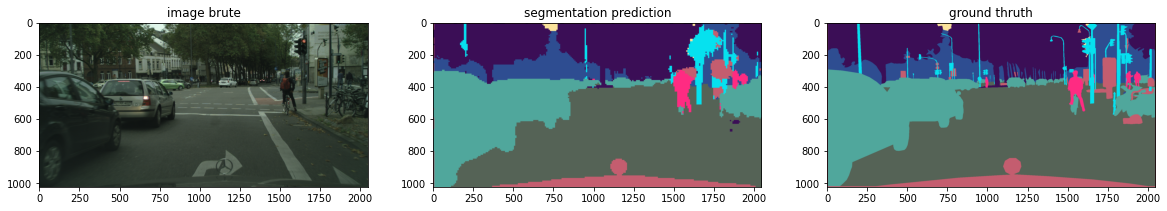

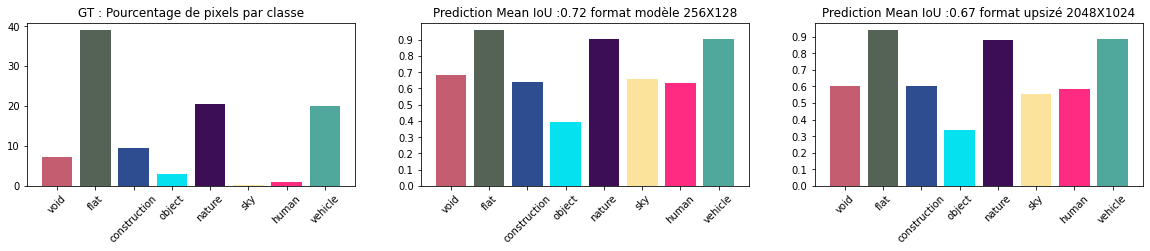

In [23]:
adress="input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test/aachen/aachen_000010_000019_leftImg8bit.png"
gt_adress="input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/aachen/aachen_000010_000019_gtFine_labelIds.png"
seg_prediction(model=model,adress=adress,gt_adress=gt_adress)

In [17]:

nb_img_train=2303
batch_size=15
steps_per_epoch=nb_img_train//batch_size #les generaturs sont infinis , on definit un nombre fictif de pas par epoch pour definir fictivement une epoch
nb_img_test=403
val_steps_per_epoch=nb_img_test//batch_size
epochs=50
initial_epoch=0

model.fit(x=im_seg_generator(img_seg_pairs=im_seg_pairs()[0], batch_size=batch_size, with_aug=False, other_aug=0),
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=im_seg_generator(img_seg_pairs=im_seg_pairs()[1], batch_size=batch_size, with_aug=False, other_aug=0),
          validation_steps=val_steps_per_epoch,  
          callbacks=callbacks)
          #use_multiprocessing=False, 
          #initial_epoch=initial_epoch)
          #workers=2)

Epoch 1/50
153/153 [==============================] - 655s 4s/step - loss: 0.8833 - mean_dice: 0.3787 - mean_iou: 0.2681 - flat_dice: 0.5812 - flat_iou: 0.4121 - accuracy: 0.6844 - val_loss: 0.9426 - val_mean_dice: 0.3734 - val_mean_iou: 0.2656 - val_flat_dice: 0.6031 - val_flat_iou: 0.4320 - val_accuracy: 0.6907

Epoch 00001: val_mean_iou improved from -inf to 0.26555, saving model to vgg_pspnet_384_576\vgg_pspnet_0.00001
Epoch 2/50
153/153 [==============================] - 622s 4s/step - loss: 0.7125 - mean_dice: 0.4571 - mean_iou: 0.3399 - flat_dice: 0.6634 - flat_iou: 0.4968 - accuracy: 0.7609 - val_loss: 1.9756 - val_mean_dice: 0.2324 - val_mean_iou: 0.1554 - val_flat_dice: 0.4632 - val_flat_iou: 0.3016 - val_accuracy: 0.4857

Epoch 00002: val_mean_iou did not improve from 0.26555
Epoch 3/50
153/153 [==============================] - 622s 4s/step - loss: 0.6608 - mean_dice: 0.4824 - mean_iou: 0.3646 - flat_dice: 0.6868 - flat_iou: 0.5235 - accuracy: 0.7816 - val_loss: 1.2164 - va

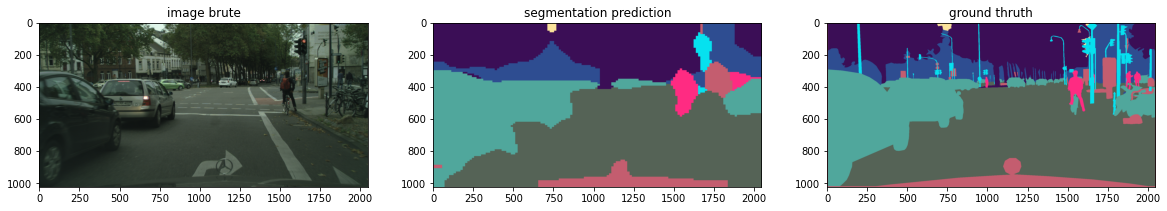

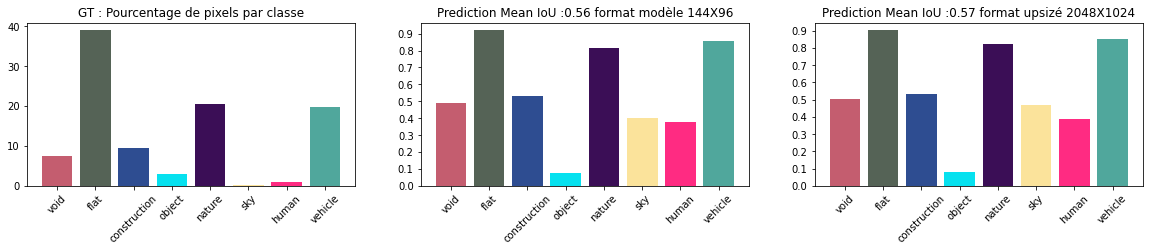

In [30]:
adress="input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test/aachen/aachen_000010_000019_leftImg8bit.png"
gt_adress="input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/aachen/aachen_000010_000019_gtFine_labelIds.png"
seg_prediction(model=model,adress=adress,gt_adress=gt_adress)

In [14]:
#790 sec par epoch sans aug
#923 sec - 15 min par epoch avec aug
nb_img_train=10000
batch_size=15
steps_per_epoch=nb_img_train//batch_size #les generaturs sont infinis , on definit un nombre fictif de pas par epoch pour definir fictivement une epoch
nb_img_test=nb_img_train//5
val_steps_per_epoch=nb_img_test//batch_size
epochs=10
initial_epoch=0

model_info=model.fit(x=im_seg_generator(img_seg_pairs=im_seg_pairs()[0], batch_size=batch_size, with_aug=True, other_aug=0),
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=im_seg_generator(img_seg_pairs=im_seg_pairs()[1], batch_size=batch_size, with_aug=True, other_aug=0),
          validation_steps=val_steps_per_epoch,  
          callbacks=callbacks)
          #use_multiprocessing=False, 
          #initial_epoch=initial_epoch)
          #workers=2)

Epoch 1/10
666/666 [==============================] - 923s 1s/step - loss: 0.7527 - mean_dice: 0.4703 - mean_iou: 0.3583 - flat_dice: 0.6632 - flat_iou: 0.5096 - accuracy: 0.7633 - val_loss: 0.4655 - val_mean_dice: 0.5917 - val_mean_iou: 0.4770 - val_flat_dice: 0.7902 - val_flat_iou: 0.6537 - val_accuracy: 0.8500

Epoch 00001: mean_iou improved from -inf to 0.43703, saving model to tmp\vgg_unet_2.00001
Epoch 2/10
666/666 [==============================] - 880s 1s/step - loss: 0.3804 - mean_dice: 0.6396 - mean_iou: 0.5292 - flat_dice: 0.8205 - flat_iou: 0.6961 - accuracy: 0.8775 - val_loss: 0.3867 - val_mean_dice: 0.6565 - val_mean_iou: 0.5442 - val_flat_dice: 0.8296 - val_flat_iou: 0.7094 - val_accuracy: 0.8787

Epoch 00002: mean_iou improved from 0.43703 to 0.53966, saving model to tmp\vgg_unet_2.00002
Epoch 3/10
666/666 [==============================] - 876s 1s/step - loss: 0.3355 - mean_dice: 0.6753 - mean_iou: 0.5658 - flat_dice: 0.8403 - flat_iou: 0.7250 - accuracy: 0.8906 - val_

In [15]:
nb_img_train=1000
batch_size=15
steps_per_epoch=nb_img_train//batch_size #les generaturs sont infinis , on definit un nombre fictif de pas par epoch pour definir fictivement une epoch
nb_img_test=nb_img_train/5
val_steps_per_epoch=nb_img_test//batch_size
epochs=5
initial_epoch=0

model.fit(x=im_seg_generator(img_seg_pairs=im_seg_pairs()[0], batch_size=batch_size, with_aug=False, other_aug=0),
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=im_seg_generator(img_seg_pairs=im_seg_pairs()[1], batch_size=batch_size, with_aug=False, other_aug=0),
          validation_steps=val_steps_per_epoch,  
          callbacks=callbacks)
          #use_multiprocessing=False, 
          #initial_epoch=initial_epoch)
          #workers=2)

Epoch 1/5
66/66 [==============================] - 105s 1s/step - loss: 1.3349 - mean_dice: 0.3165 - mean_iou: 0.2144 - flat_dice: 0.4572 - flat_iou: 0.3066 - accuracy: 0.5933 - val_loss: 1.6685 - val_mean_dice: 0.4138 - val_mean_iou: 0.2947 - val_flat_dice: 0.5820 - val_flat_iou: 0.4111 - val_accuracy: 0.6174

Epoch 00001: val_accuracy improved from -inf to 0.61744, saving model to tmp\vgg_unet_1.00001
Epoch 2/5
66/66 [==============================] - 76s 1s/step - loss: 0.6378 - mean_dice: 0.5157 - mean_iou: 0.3963 - flat_dice: 0.7150 - flat_iou: 0.5572 - accuracy: 0.8073 - val_loss: 0.7556 - val_mean_dice: 0.4997 - val_mean_iou: 0.3729 - val_flat_dice: 0.6655 - val_flat_iou: 0.4992 - val_accuracy: 0.7627

Epoch 00002: val_accuracy improved from 0.61744 to 0.76271, saving model to tmp\vgg_unet_1.00002
Epoch 3/5
66/66 [==============================] - 76s 1s/step - loss: 0.5197 - mean_dice: 0.5724 - mean_iou: 0.4546 - flat_dice: 0.7620 - flat_iou: 0.6158 - accuracy: 0.8407 - val_los

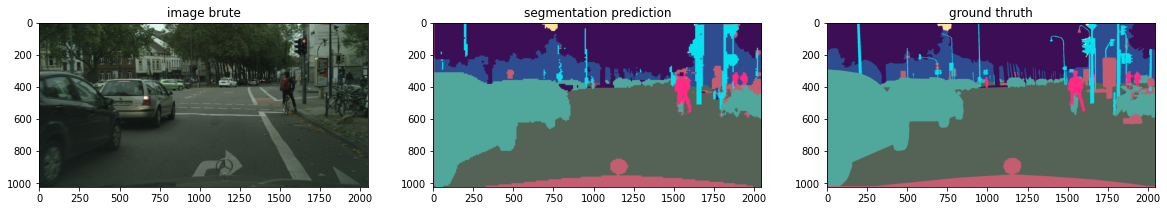

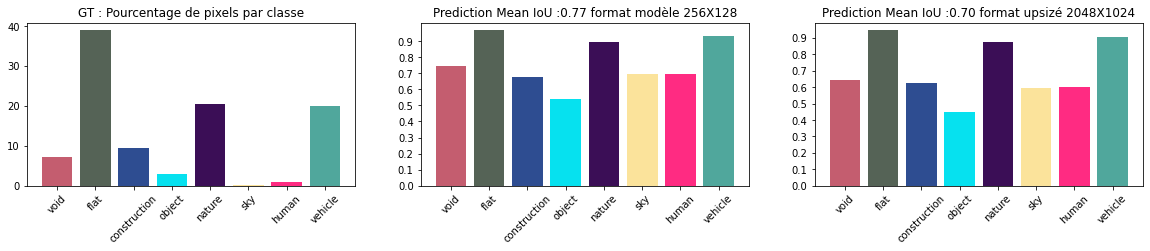

In [202]:
adress="input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test/aachen/aachen_000010_000019_leftImg8bit.png"
gt_adress="input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/aachen/aachen_000010_000019_gtFine_labelIds.png"
seg_prediction(model=mod,adress=adress,gt_adress=gt_adress)

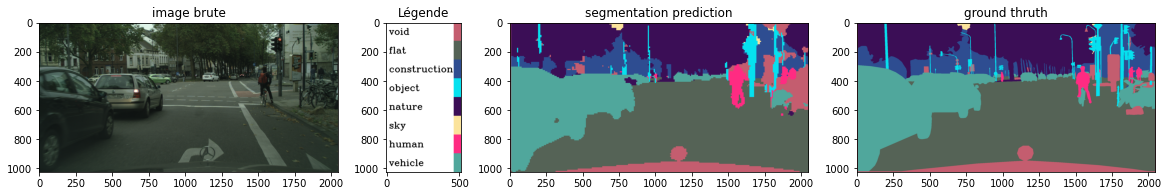

In [22]:
#model vgg_unet4 256x512 50 epochs de 2303/403 sans augmentation
adress="input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test/aachen/aachen_000010_000019_leftImg8bit.png"
gt_adress="input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/aachen/aachen_000010_000019_gtFine_labelIds.png"
seg_prediction(model=model,adress=adress,gt_adress=gt_adress)